In [1]:
import networks
from visualize_utils import *
import torch
import matplotlib.pyplot as plt
import utils
from depth_anything import dpt
import cv2
import torch
import layers
import torch.nn.functional as F
import torch.nn as nn
from einops import rearrange
import layers
import numpy as np

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
models = load_models("./logs_masked/suppress_A_reprojection/models/weights_19")

/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zhouy/miniconda3/envs/da2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
frame_indices = [0, -1, 1]

def pose_predict(models, images, outputs):
    pose_feats = {
        f_i: images[f_i + 1].unsqueeze(0) for f_i in frame_indices
    }
    for f_i in frame_indices[1:]:
        if f_i < 0:
            inputs_all = [pose_feats[f_i], pose_feats[0]]
        else:
            inputs_all = [pose_feats[0], pose_feats[f_i]]
    
        pose_inputs = [models["pose_encoder"](torch.cat(inputs_all, 1))]
        axisangle, translation = models["pose"](pose_inputs)

        outputs[("axisangle", f_i)] = axisangle
        outputs[("translation", f_i)] = translation
        outputs[("cam_T_cam", f_i)] = layers.transformation_from_parameters(
            axisangle[:, 0], translation[:, 0], invert=(f_i < 0))

K = np.array([[0.82, 0, 0.5, 0],
            [0, 1.02, 0.5, 0],
            [0, 0, 1, 0],
            [0, 0, 0, 1]], dtype=np.float32)
K[0, :] *= 320
K[1, :] *= 256
inv_K = np.linalg.pinv(K)
K = torch.from_numpy(K).cuda().unsqueeze(0)
inv_K = torch.from_numpy(inv_K).cuda().unsqueeze(0)

B = 1
T = 3
width = 320
height = 256
patch = 16
Hp = height // patch
Wp = width // patch


In [4]:
device = "cuda"
image_loader = ImageLoader(6, 3)
image = image_loader.batch([2,3,4])
# image.shape: (3, 3, 256, 320)
# image.shape: (T, C, H, W)
decompose_feats = models["decompose_encoder"](image)
decompose_result = models["decompose"](decompose_feats, image)
A = decompose_result["A"]
M = decompose_result["M"]
# A.shape: (T, C, H, W)
# M.shape: (T, 1, H, W)
disp = models["depth"](image[1].unsqueeze(0))
outputs = {}
pose_predict(models, image, outputs)

# backproject 部分
MIN_DEPTH = 1e-3
MAX_DEPTH = 150
_, depth = utils.disp_to_depth(disp, MIN_DEPTH, MAX_DEPTH)
back_project = layers.BackprojectDepth(1, 256, 320)
back_project.to(device)
project_3d = layers.Project3D(1, 256, 320)
project_3d.to(device)

input_A = []
input_M = []
for f_i in frame_indices[1:]:
    T = outputs[("cam_T_cam", f_i)]
    cam_points = back_project(depth, inv_K)
    pix_coords = project_3d(cam_points, K, T)
    A_warp = F.grid_sample(
            A[f_i + 1].unsqueeze(0),
            pix_coords,
            padding_mode="border",
            align_corners=True
        )
    outputs[("A_warp", f_i)] = A_warp
    input_A.append(A_warp)
    M_warp = F.grid_sample(
            M[f_i + 1].unsqueeze(0),
            pix_coords,
            padding_mode="border",
            align_corners=True
        )
    outputs[("M_warp", f_i)] = M_warp
    input_M.append(M_warp)

input_A.insert(1, A[1].unsqueeze(0))
input_M.insert(1, M[1].unsqueeze(0))

# (B, T, C, H, W)
input_A = torch.stack(input_A, dim=1)
input_M = torch.stack(input_M, dim=1)
sup_res = models["reflection"](input_A, input_M)


### 绘制sup结果

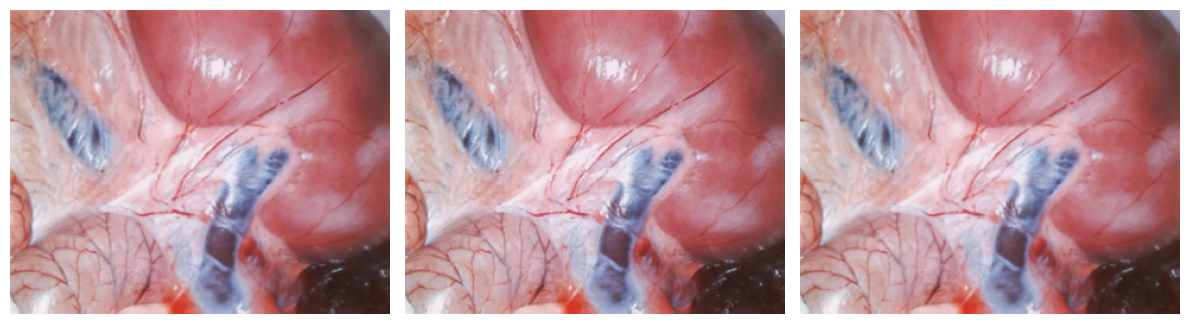

In [5]:
plot_images(sup_res.squeeze(0))

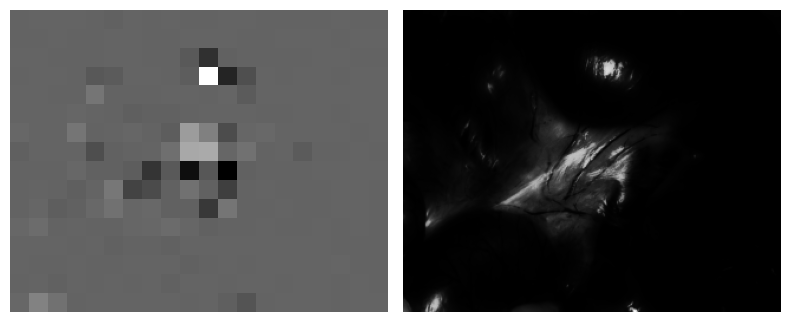

tensor(70, device='cuda:0')


In [ ]:
# models["reflection"].mask_embed.shape: torch.Size([320, 3])
mask_embed = models["reflection"].mask_embed
max_ind = torch.argmax(mask_embed[:, 1])
mask_embed = rearrange(mask_embed, "(Hp Wp) T -> T Hp Wp", Hp=Hp, Wp=Wp)
plot_images([mask_embed[1].unsqueeze(0), M[1]])
print(max_ind)

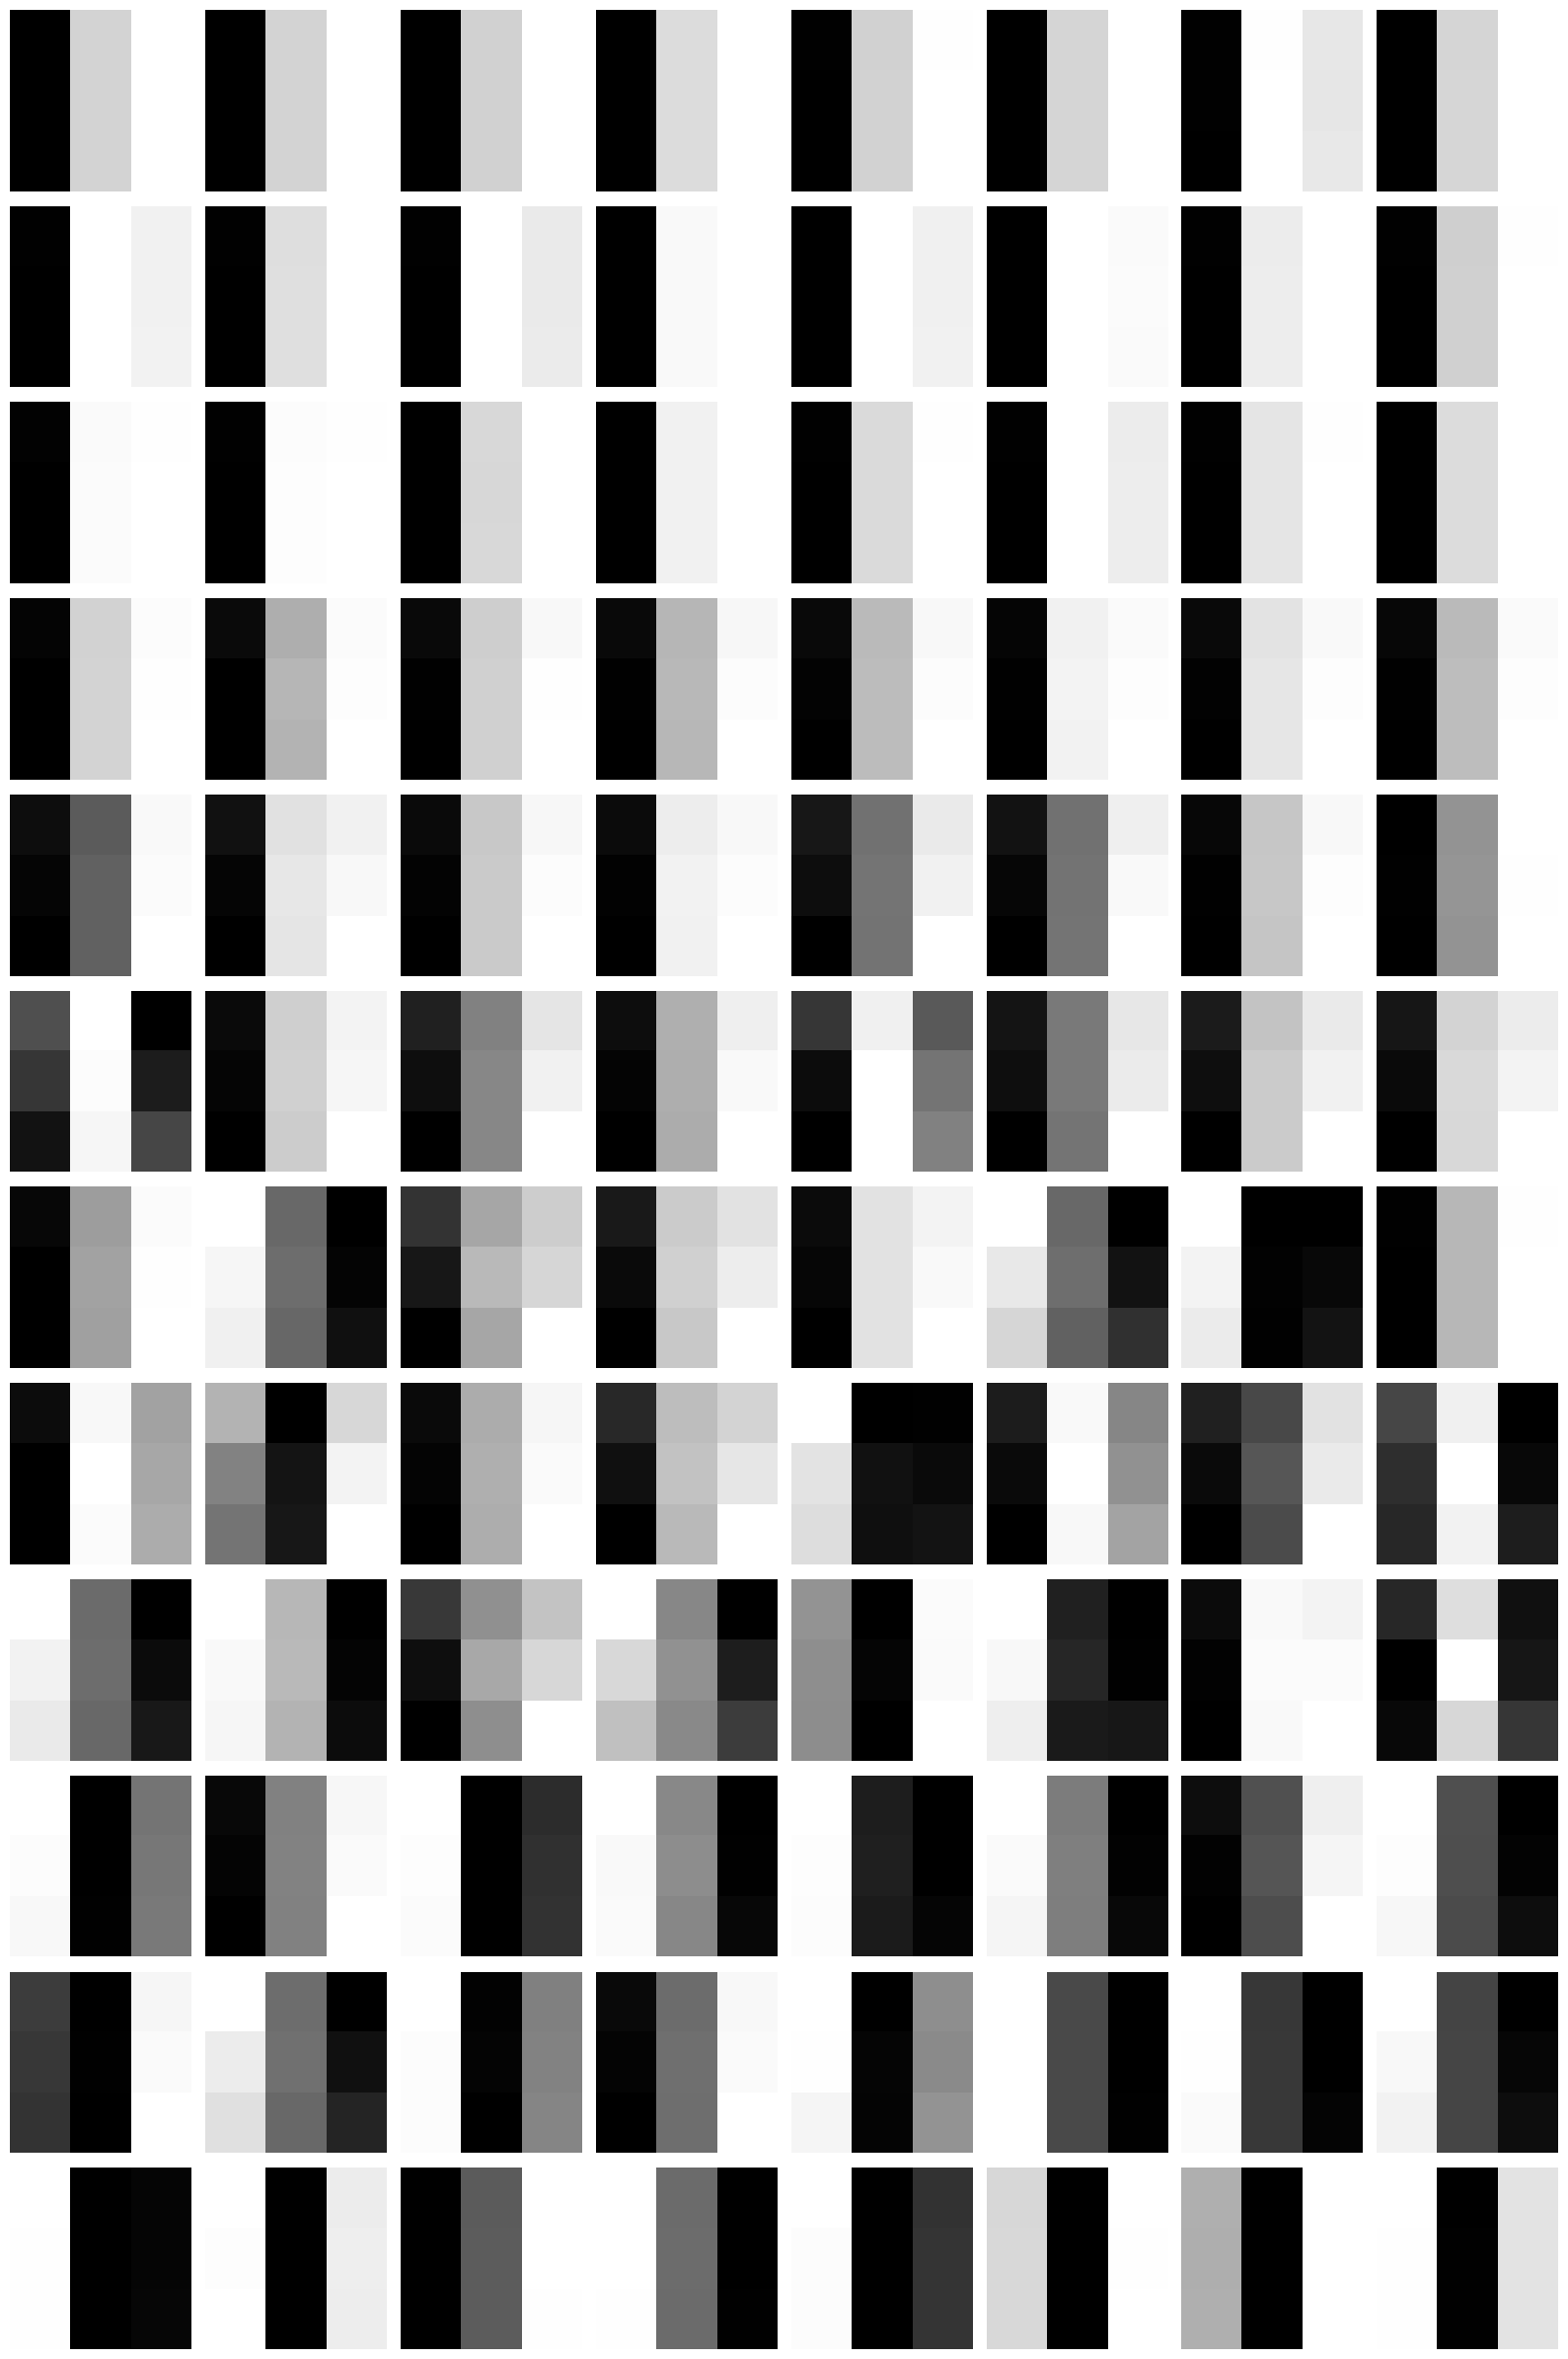

In [13]:
# models["reflection"].temporal_attention_maps[0].shape: torch.Size([320, 8, 3, 3])
images_to_show = []
for i in range(12):
    attn = models["reflection"].temporal_attention_maps[i] # torch.Size([320, 8, 3, 3])
    for j in range(8):
        images_to_show.append(attn[0, j].unsqueeze(0))

plot_images(images_to_show, lines=12, per_col_width=2, per_row_height=2)



### 其他